# Import Library

In [19]:
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from math import radians, cos, sin, asin, sqrt

# Load Dataset

In [4]:
df_customers = pd.read_csv("../data/olist_customers_dataset.csv")
df_sellers = pd.read_csv("../data/olist_sellers_dataset.csv")
df_geo = pd.read_csv("../data/olist_geolocation_dataset.csv")

# Preprocessing

In [5]:
df_geo_grouped = df_geo.groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]].mean().reset_index()
df_geo_grouped.columns = ["zip_code_prefix", "lat", "lng"]

In [ ]:
# merge ke Customer & Seller
df_customers["zip_code_prefix"] = df_customers["customer_zip_code_prefix"]
df_sellers["zip_code_prefix"] = df_sellers["seller_zip_code_prefix"]

df_customers = df_customers.merge(df_geo_grouped, on="zip_code_prefix", how="left")
df_sellers = df_sellers.merge(df_geo_grouped, on="zip_code_prefix", how="left")

In [7]:
# GeoDataFrame
gdf_customers = gpd.GeoDataFrame(df_customers, geometry=gpd.points_from_xy(df_customers.lng, df_customers.lat), crs="EPSG:4326")
gdf_sellers = gpd.GeoDataFrame(df_sellers, geometry=gpd.points_from_xy(df_sellers.lng, df_sellers.lat), crs="EPSG:4326")

# Visualisasi

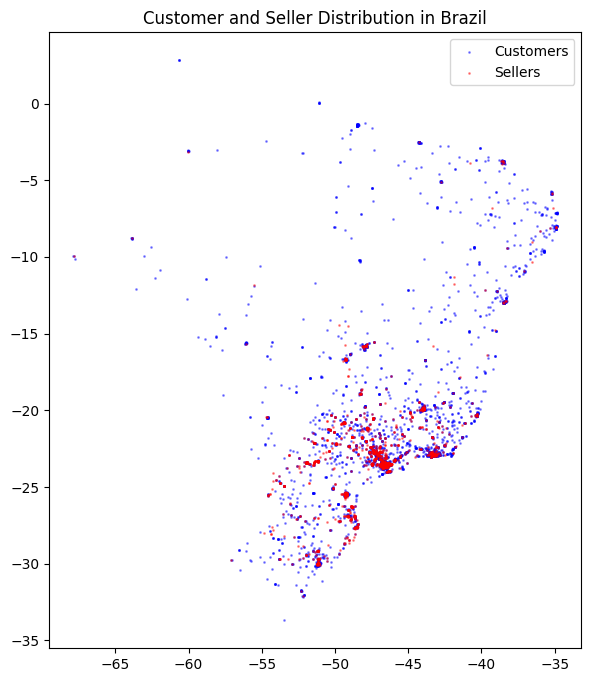

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf_customers.sample(5000).plot(ax=ax, markersize=1, color='blue', label='Customers', alpha=0.4)
gdf_sellers.sample(2000).plot(ax=ax, markersize=1, color='red', label='Sellers', alpha=0.4)
plt.title("Customer and Seller Distribution in Brazil")
plt.legend()
plt.show()

# Analisis Jarak

In [ ]:
# fungsi Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius bumi dalam km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c


In [28]:
# Contoh 1.000 pasang acak
sample = pd.merge(
    df_customers.dropna().sample(2500, random_state=42),
    df_sellers.dropna().sample(2500, random_state=42),
    how='inner',
    left_index=True,
    right_index=True,
    suffixes=('_cust', '_seller')
)

sample['distance_km'] = sample.apply(
    lambda row: haversine(row['lat_cust'], row['lng_cust'], row['lat_seller'], row['lng_seller']), axis=1
)

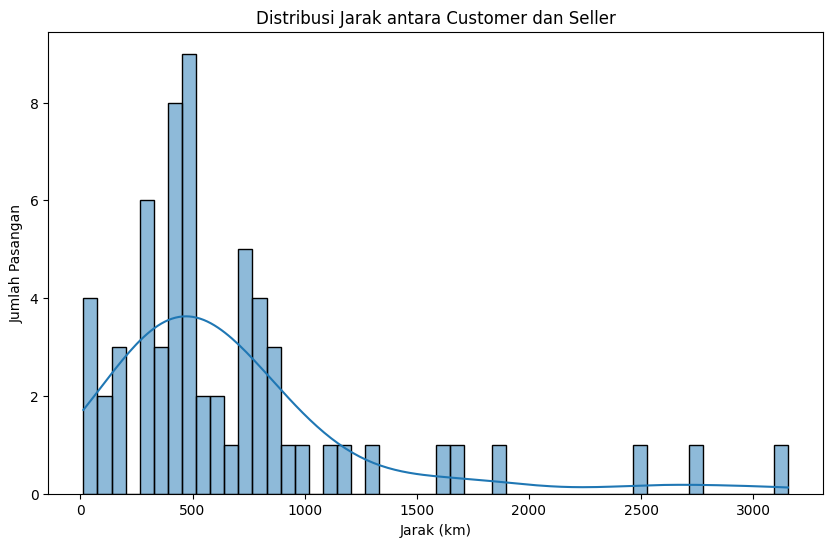

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(sample['distance_km'], bins=50, kde=True)
plt.title("Distribusi Jarak antara Customer dan Seller")
plt.xlabel("Jarak (km)")
plt.ylabel("Jumlah Pasangan")
plt.show()

# Peta Interaktif

In [23]:
# Buat peta dasar di Brazil
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

# Tambahkan titik customer
for _, row in gdf_customers.dropna().sample(1000).iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lng']),
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.4
    ).add_to(m)

# Tambahkan titik seller
for _, row in gdf_sellers.dropna().sample(1000).iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lng']),
        radius=2,
        color='red',
        fill=True,
        fill_opacity=0.4
    ).add_to(m)

m.save("../notebooks/map_customer_seller.html")
